In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from time import perf_counter

class SID:
    """
    Implements Spacing-Increasing Discretization as described in the DORN paper.

    Discretizes the region [alpha, beta]
    Offset controls spacing even further by discretizing [alpha + offset, beta + offset] and then
    subtracting offset from all bin edges.

    Bonus: Includes support for when the index is -1 (in which case the value should be alpha)
    and when it is sid_bins (in which case the value should be beta).

    Works in numpy.
    """
    def __init__(self, sid_bins, alpha, beta, offset):
        self.sid_bins = sid_bins
        self.alpha = alpha
        self.beta = beta
        self.offset = offset

        # Derived quantities
        self.alpha_star = self.alpha + offset
        self.beta_star = self.beta + offset
        bin_edges = np.array(range(sid_bins + 1)).astype(np.float32)
        self.sid_bin_edges = np.array(np.exp(np.log(self.alpha_star) +
                                             bin_edges / self.sid_bins * np.log(self.beta_star / self.alpha_star)))
        self.sid_bin_values = (self.sid_bin_edges[:-1] + self.sid_bin_edges[1:]) / 2 - self.offset
        self.sid_bin_values = np.append(self.sid_bin_values, [self.alpha, self.beta])
        # Do the above so that:
        # self.sid_bin_values[-1] = self.alpha < self.sid_bin_values[0]
        # and
        # self.sid_bin_values[sid_bins] = self.beta > self.sid_bin_values[sid_bins-1]

    def get_sid_index_from_value(self, arr):
        """
        Given an array of values in the range [alpha, beta], return the
        indices of the bins they correspond to
        :param arr: The array to turn into indices.
        :return: The array of indices.
        """
        sid_index = np.floor(self.sid_bins * (np.log(arr + self.offset) - np.log(self.alpha_star)) /
                                             (np.log(self.beta_star) - np.log(self.alpha_star))).astype(np.int32)
        sid_index = np.clip(sid_index, a_min=-1, a_max=self.sid_bins)
        # An index of -1 indicates alpha, while self.sid_bins indicates beta
        return sid_index

    def get_value_from_sid_index(self, sid_index):
        """
        Given an array of indices in the range {-1, 0,...,sid_bins},
        return the representative value of the selected bin.
        :param sid_index: The array of indices.
        :return: The array of values correspondding to those indices
        """
        return np.take(self.sid_bin_values, sid_index)

    def __repr__(self):
        return repr((self.sid_bins, self.alpha, self.beta, self.offset))


In [38]:
# Load actual depth image
from matplotlib._png import read_png
orig = read_png("data/4597_depth.png")
orig = (orig - np.min(orig))/(np.max(orig) - np.min(orig))
new_max = 2
new_min = 0.8
sid_obj = SID(sid_bins=68, alpha=0.6569154266167957, beta=9.972175646365525, offset=0)

# Make ground truth
gt = orig * new_max + new_min

# Make shifted image
sh = gt + 1.

# Load RGB image
albedo = read_png("data/4597_albedo.png")
intensity = 0.2989 * albedo[..., 0] + 0.5870 * albedo[..., 1] + 0.1140 * albedo[..., 2]

In [3]:
def find_movement(hist_from, hist_to):
    """Gives the movements from hist_from (column sum)
    to hist_to (row sum).
    
    Based on Morovic et. al 2002 A fast, non-iterative, and exact histogram matching algorithm.
    
    hist_from and hist_to should sum to the same value
    """
    movement = np.zeros((len(hist_from), len(hist_to)))
    for row in range(len(hist_from)):
        for col in range(len(hist_to)):
            pixels_rem = hist_from[row] - np.sum(movement[row, :col])
            pixels_req = hist_to[col] - np.sum(movement[:row, col])

            movement[row, col] = np.minimum(pixels_rem, pixels_req)
    return movement

def move_pixels(T, init_index, weights):
    assert init_index.shape == weights.shape
    pred_index = np.zeros_like(init_index)
#     marginal_nonzero = np.nonzero(np.sum(T, axis=1))[0]
    for row in range(init_index.shape[0]):
        for col in range(init_index.shape[1]):
            i = init_index[row, col]
            cpf = np.cumsum(T[i, :])
            p = np.random.uniform(0, cpf[-1])
            for j in range(len(cpf)):
                if cpf[j] >= p:
                    pred_index[row, col] = j
                    T[i, j] = np.maximum(T[i, j] - weights[row, col], 0.)
                    break
    return pred_index

def move_pixels_raster(T_count, init_index, weights):
    assert init_index.shape == weights.shape
    marginal_nonzero = np.nonzero(np.sum(T_count, axis=1))[0]
    pred_index = np.zeros_like(init_index)
    index_sets = [np.where(init_index == bin_index) for bin_index in range(T_count.shape[1])]
    for old_bin in marginal_nonzero: # Indexes rows
#         weight_moved = 0
        curr = 0
        for new_bin in range(T_count.shape[1]): # Indexes columns
            weight_to_move = T_count[old_bin, new_bin]
            rows, cols = index_sets[old_bin]
            weight_moved = 0.
            while weight_moved < weight_to_move and curr < len(rows):
                weight_moved += weights[rows[curr], cols[curr]]
                pred_index[rows[curr], cols[curr]] = new_bin
                curr += 1
    return pred_index
    

def image_histogram_match(init, gt_hist, weights, sid_obj, opt_eps=1e-4):
    weights = weights * (np.sum(gt_hist)/np.sum(init_weights))
    init_index = np.clip(sid_obj.get_sid_index_from_value(init), a_min=0, a_max=sid_obj.sid_bins-1)
    init_hist, _ = np.histogram(init_index, weights=weights, bins=range(sid_obj.sid_bins + 1))
    T_count = find_movement(init_hist, gt_hist)
    pred_index = move_pixels_raster(T_count, init_index, weights)
    pred = sid_obj.get_value_from_sid_index(pred_index)
    pred_hist, _ = np.histogram(pred_index, weights=weights, bins=range(len(gt_hist) + 1))
    return pred, (init_index, init_hist, pred_index, pred_hist, T_count)


def summarize_in_subplot(axs, col, img, hist, gt, gt_hist, title):
    axs[0, col].set_title(title, fontsize=24)
    axs[0, col].imshow(img, vmin=0., vmax=10.)
    axs[0, col].axis('off')
    axs[1, col].bar(range(len(hist)), hist)
    rmse = np.sqrt(np.mean((gt - img)**2))
#     wass, T = wasserstein_loss(hist/np.sum(hist),
#                                gt_hist/np.sum(gt_hist),
#                                cost_mat, eps_abs=1e-10)
#     axs[1,col].set_xlabel("RMSE = {:1.3f}, WASS = {:1.3f}".format(rmse, wass), fontsize=24)
    axs[1,col].set_xlabel("RMSE = {:1.3f}".format(rmse), fontsize=24)

In [6]:
def run_and_display(init, gt, init_weights, gt_weights, sid_obj, title):
    # Scale init_weights and gt_weights to have the same sum:
#     init_weights = init_weights * (init_weights.size/np.sum(init_weights))
#     init_index = np.clip(sid_obj.get_sid_index_from_value(init), a_min=0, a_max=sid_obj.sid_bins-1)
#     init_hist, _ = np.histogram(init_index, weights=init_weights, bins=range(sid_obj.sid_bins + 1))
    gt_index = np.clip(sid_obj.get_sid_index_from_value(gt), a_min=0, a_max=sid_obj.sid_bins-1)
    gt_hist, _ = np.histogram(gt_index, weights=gt_weights, bins=range(sid_obj.sid_bins + 1))

    
    start = perf_counter()
    pred, t = image_histogram_match(init, gt_hist, weights=init_weights, sid_obj=sid_obj)
    time = perf_counter() - start
    init_index, init_hist, pred_index, pred_hist, _ = t
    
    fig, axs = plt.subplots(2, 3, figsize=(30, 10),
                            gridspec_kw = {"wspace": 0.1,
                                           "height_ratios": [3, 1]})
    fontsize=24

    summarize_in_subplot(axs, 0, img=gt, hist=gt_hist, gt=gt, gt_hist=gt_hist, 
                         title="Ground Truth ({})".format(title))
    summarize_in_subplot(axs, 1, img=init, hist=init_hist, gt=gt, gt_hist=gt_hist,
                         title="Input ({})".format(title))
    summarize_in_subplot(axs, 2, img=pred, hist=pred_hist, gt=gt, gt_hist=gt_hist,
                         title="Pred ({})".format(title))
    return time


In [33]:
def summarize_gordon(inits, titles, gt, weights):
    fig, axs = plt.subplots(2, 5, figsize=(50, 10),
                            gridspec_kw = {"wspace": 0.1,
                                           "height_ratios": [3, 1]})
    fontsize=24

    gt_index = np.clip(sid_obj.get_sid_index_from_value(gt), a_min=0, a_max=sid_obj.sid_bins-1)
    gt_hist, _ = np.histogram(gt_index, weights=weights, bins=range(sid_obj.sid_bins + 1))

    summarize_in_subplot(axs, 0, img=gt, hist=gt_hist, gt=gt, gt_hist=gt_hist, 
                         title="Ground Truth")
    for i, (init, title) in enumerate(zip(inits, titles)):
        init_index = np.clip(sid_obj.get_sid_index_from_value(init), a_min=0, a_max=sid_obj.sid_bins-1)
        init_hist, _ = np.histogram(init_index, weights=weights, bins=range(sid_obj.sid_bins + 1))

        summarize_in_subplot(axs, i+1, img=init, hist=init_hist, gt=gt, gt_hist=gt_hist, 
                             title=title)
    return fig, axs

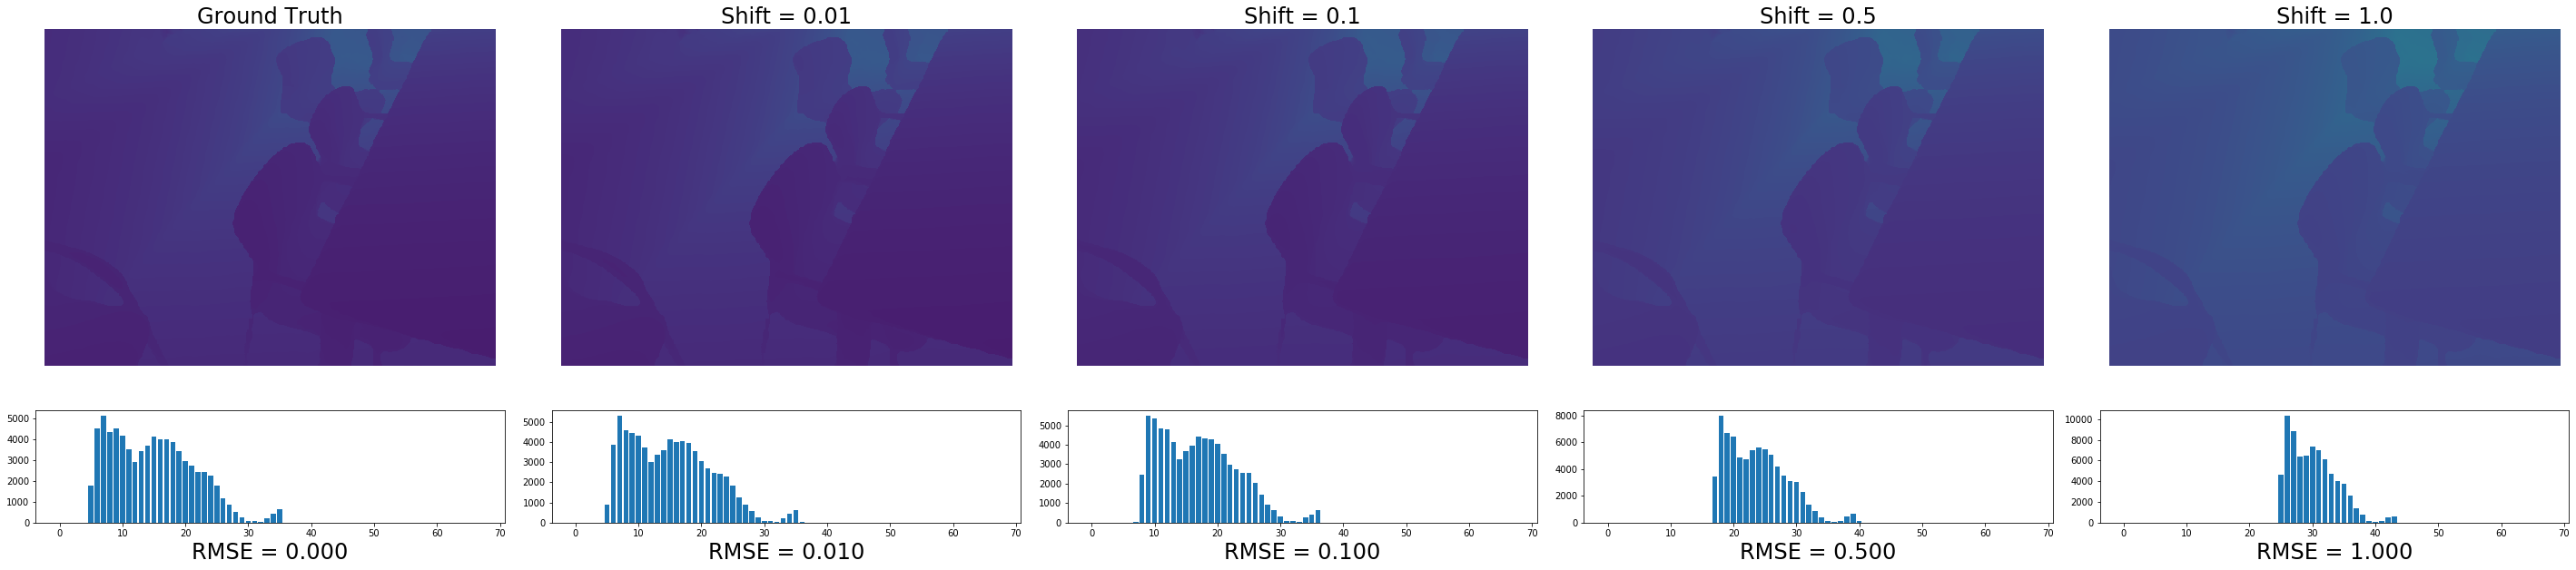

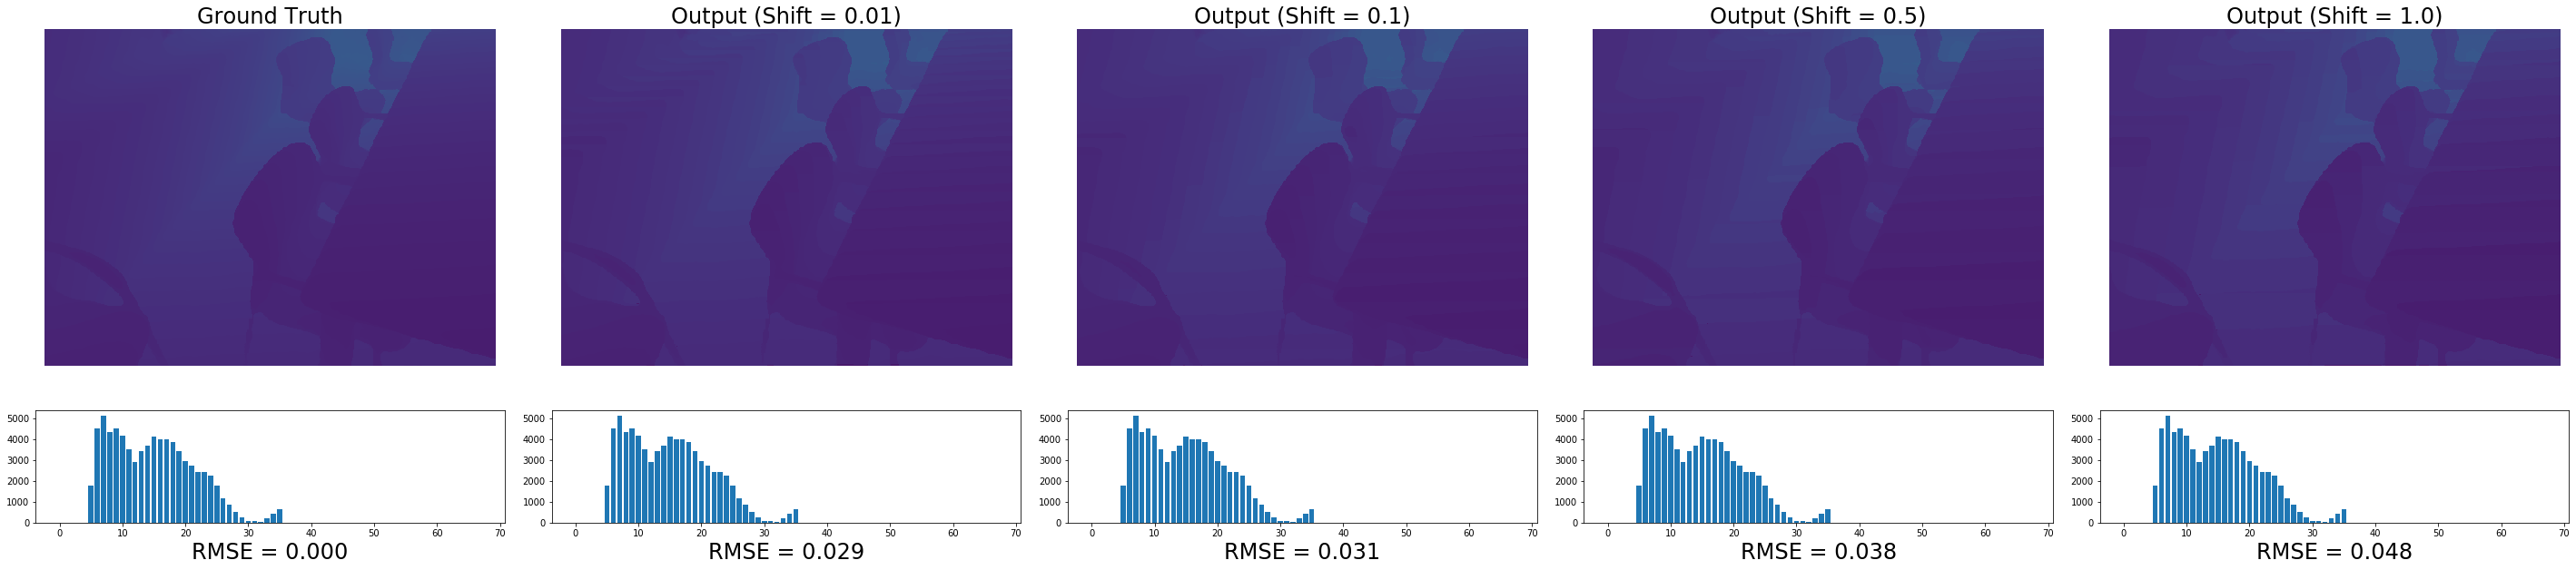

In [21]:
# Depth Shift
shifts = [0.01, 0.1, 0.5, 1.]
inits = [gt + shift for shift in shifts]
gt_index = np.clip(sid_obj.get_sid_index_from_value(gt), a_min=0, a_max=sid_obj.sid_bins-1)
gt_hist, _ = np.histogram(gt_index, weights=intensity, bins=range(sid_obj.sid_bins + 1))
summarize_gordon(inits,
                 ["Shift = {}".format(shift) for shift in shifts],
                 gt, intensity)
preds = [image_histogram_match(init, gt_hist, weights=intensity, sid_obj=sid_obj)[0] for init in inits]
# Reconstruction
summarize_gordon(preds,
                 ["Output (Shift = {})".format(shift) for shift in shifts],
                 gt, intensity)


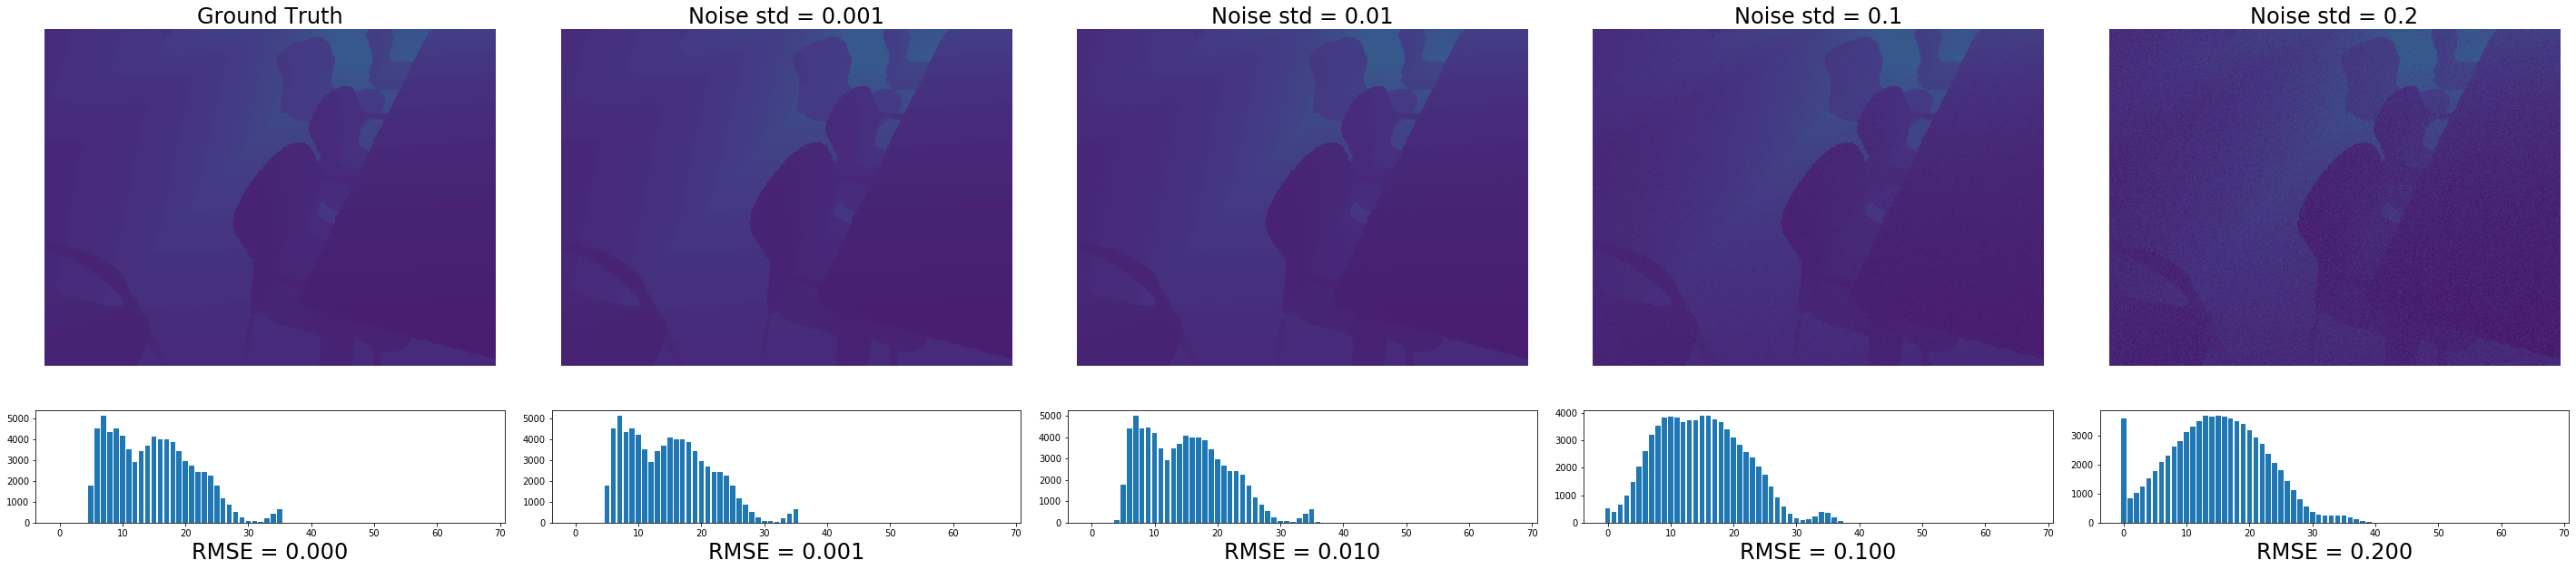

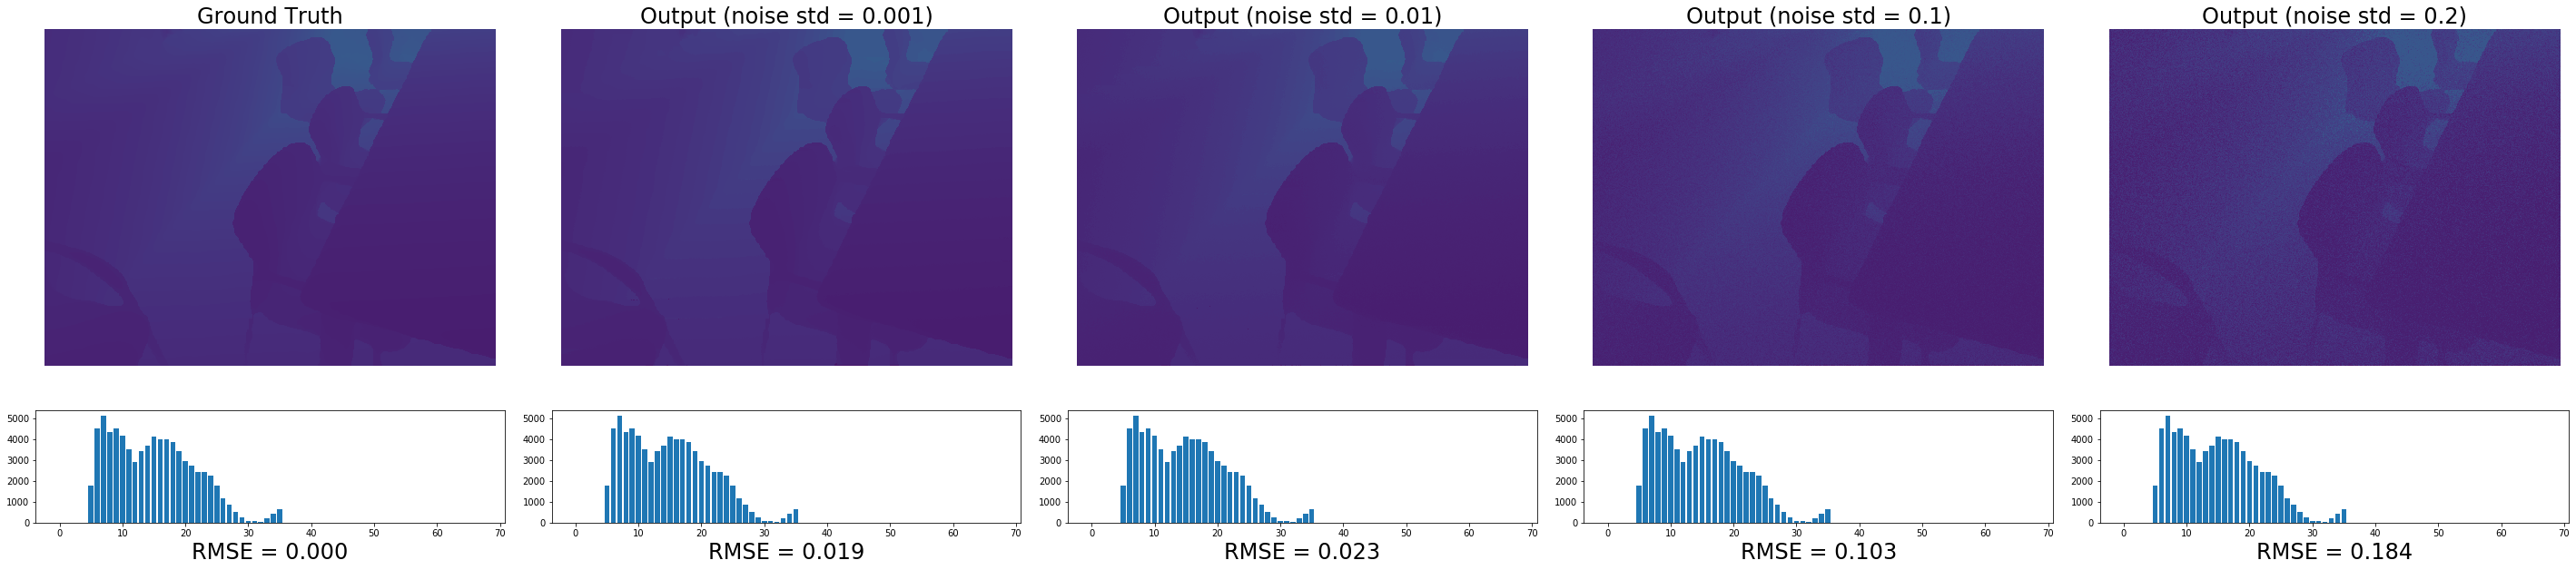

In [22]:
# Noisy Depth
noises = [0.001, 0.01, 0.1, 0.2]
inits = [np.clip(gt + noise*np.random.randn(*gt.shape), a_min=1e-4, a_max=10.) for noise in noises]
gt_index = np.clip(sid_obj.get_sid_index_from_value(gt), a_min=0, a_max=sid_obj.sid_bins-1)
gt_hist, _ = np.histogram(gt_index, weights=intensity, bins=range(sid_obj.sid_bins + 1))
summarize_gordon(inits,
                 ["Noise std = {}".format(noise) for noise in noises],
                 gt, intensity)
preds = [image_histogram_match(init, gt_hist, weights=intensity, sid_obj=sid_obj)[0] for init in inits]
# Reconstruction
summarize_gordon(preds,
                 ["Output (noise std = {})".format(noise) for noise in noises],
                 gt, intensity)

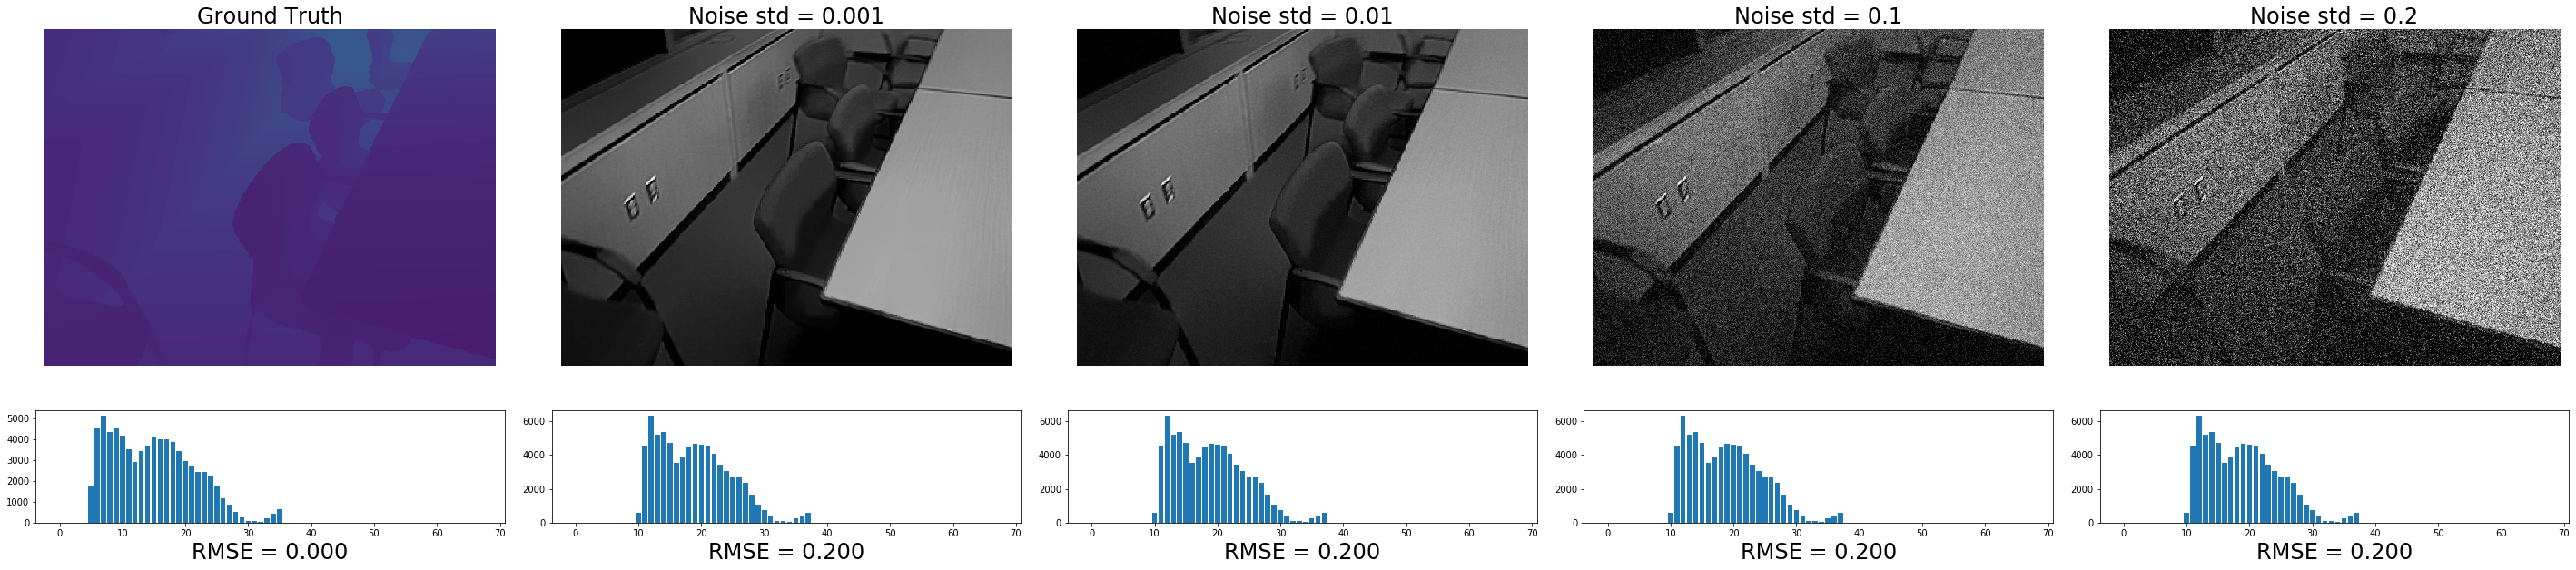

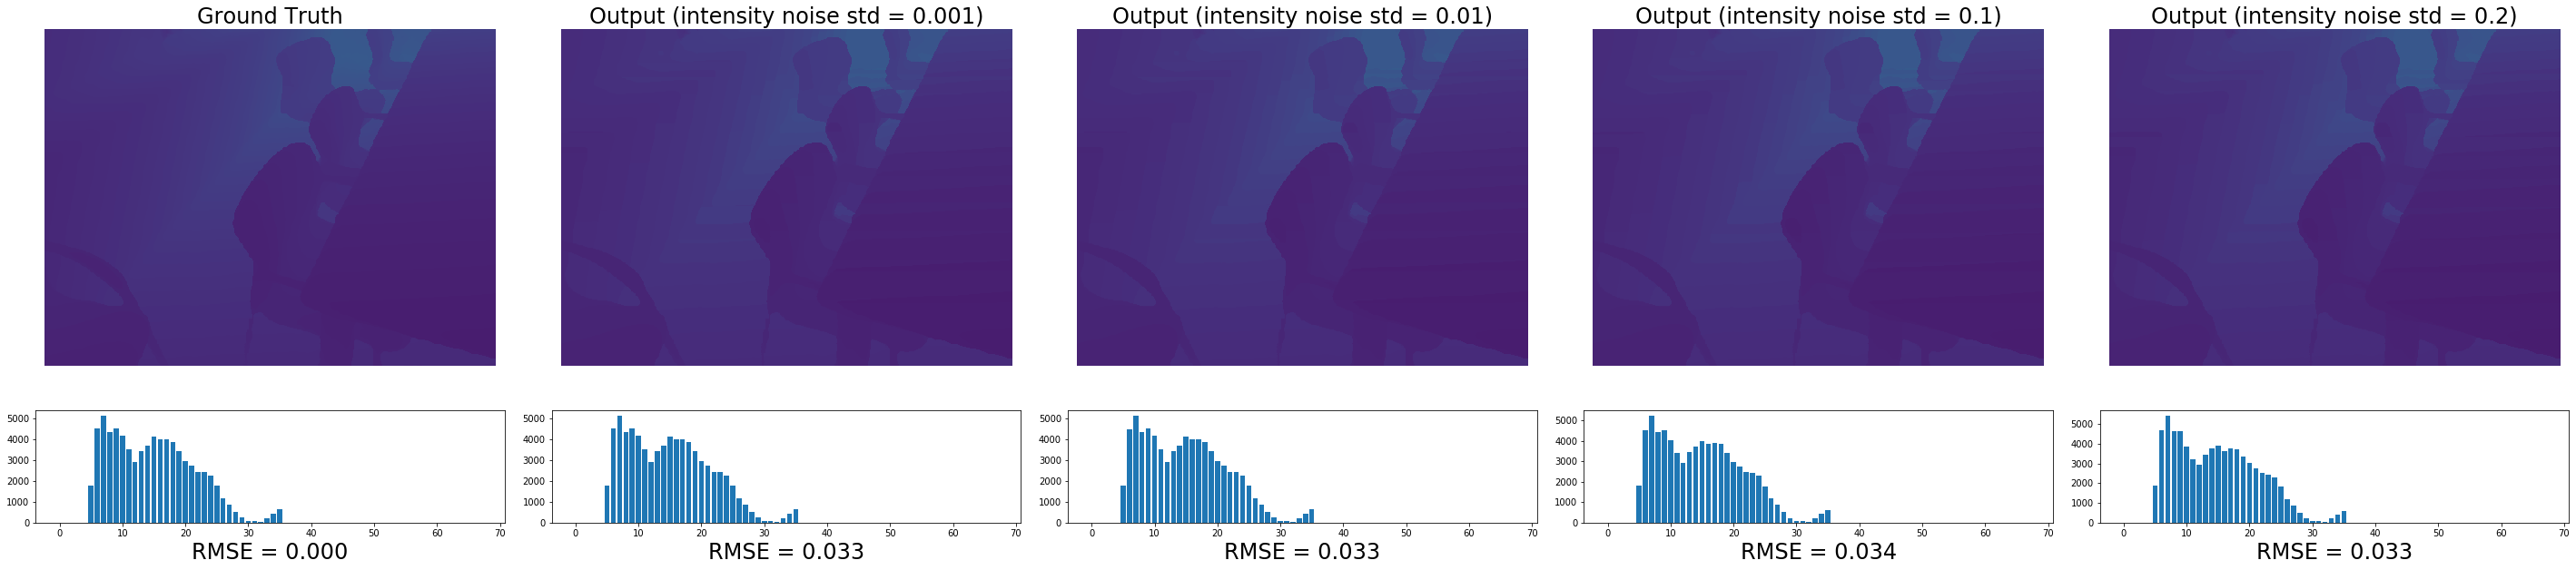

In [39]:
# Noisy Intensities
noises = [0.001, 0.01, 0.1, 0.2]
shift = 0.2
inits = [np.clip(gt + shift, a_min=1e-4, a_max=10.) for _ in range(4)]
intensities = [np.clip(intensity + noise*np.random.randn(*inits[0].shape), a_min=0., a_max=1.) for noise in noises]
gt_index = np.clip(sid_obj.get_sid_index_from_value(gt), a_min=0, a_max=sid_obj.sid_bins-1)
gt_hist, _ = np.histogram(gt_index, weights=intensity, bins=range(sid_obj.sid_bins + 1))
fig, axs = summarize_gordon(inits, ["Noise std = {}".format(noise) for noise in noises], gt, intensity)
for i, noisy_intensity in enumerate(intensities):
    axs[0, i+1].imshow(noisy_intensity, vmin=0., vmax=1., cmap='gray')
    axs[0, i+1].axis('off')
    
preds = [image_histogram_match(inits[0], gt_hist, weights=intensity,
                               sid_obj=sid_obj)[0] for intensity in intensities]
# Reconstruction
summarize_gordon(preds,
                 ["Output (intensity noise std = {})".format(noise) for noise in noises],
                 gt, intensity);

Average time: 0.6549119102501209


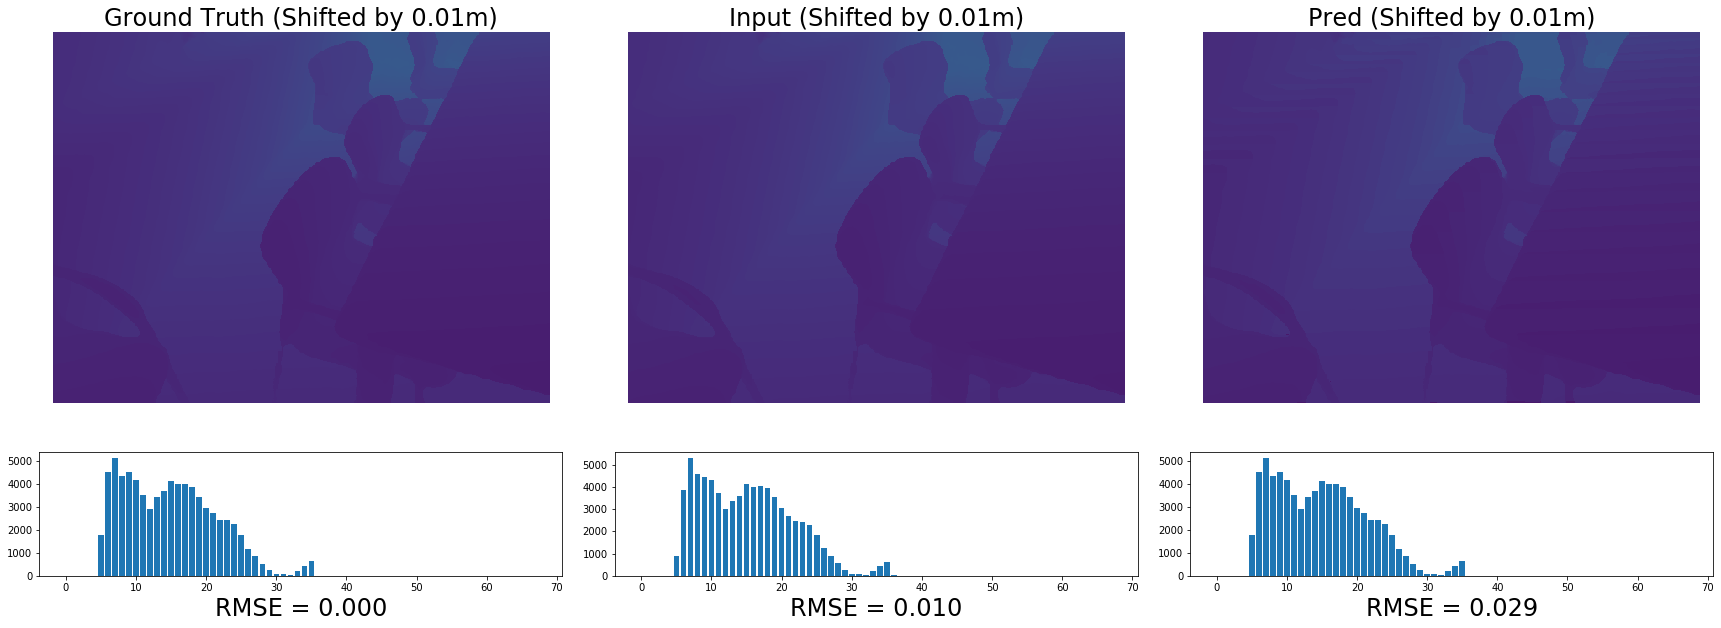

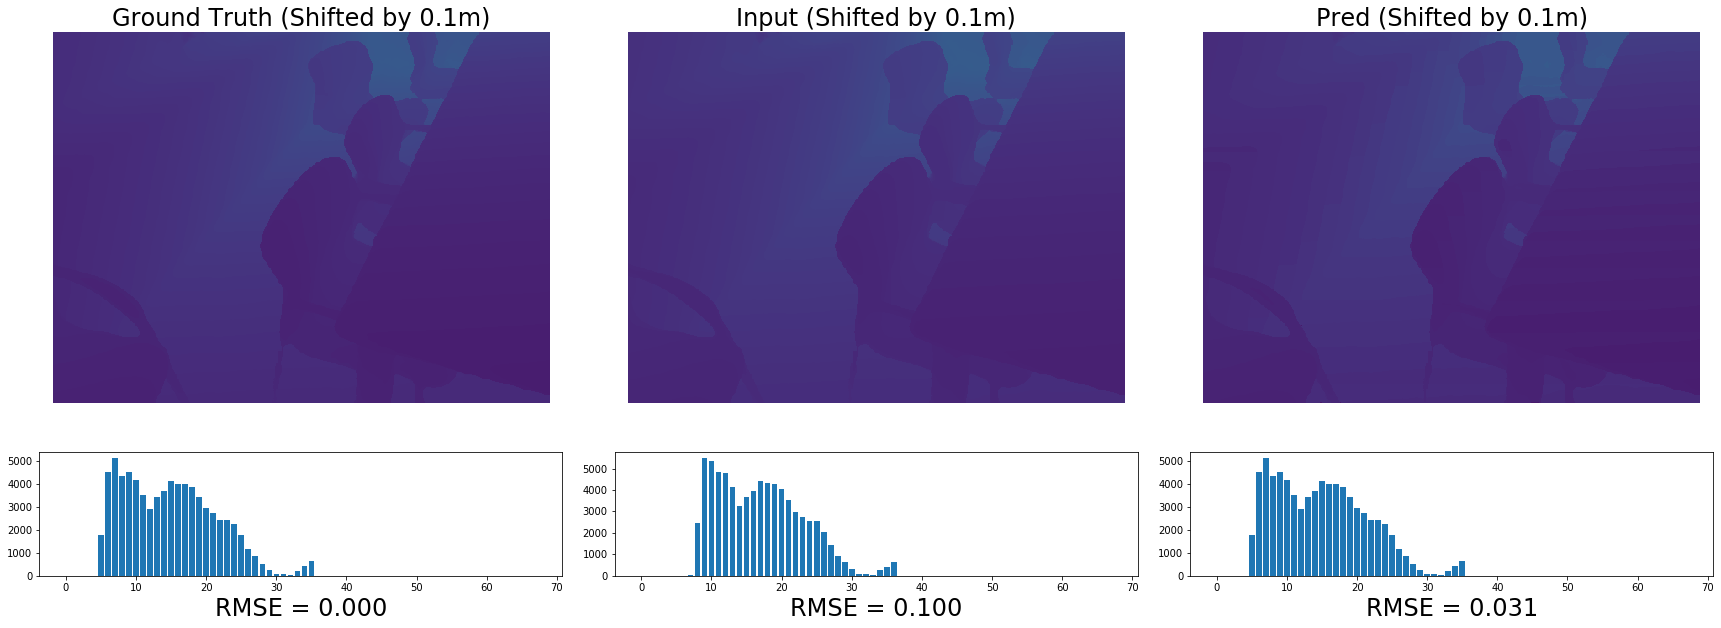

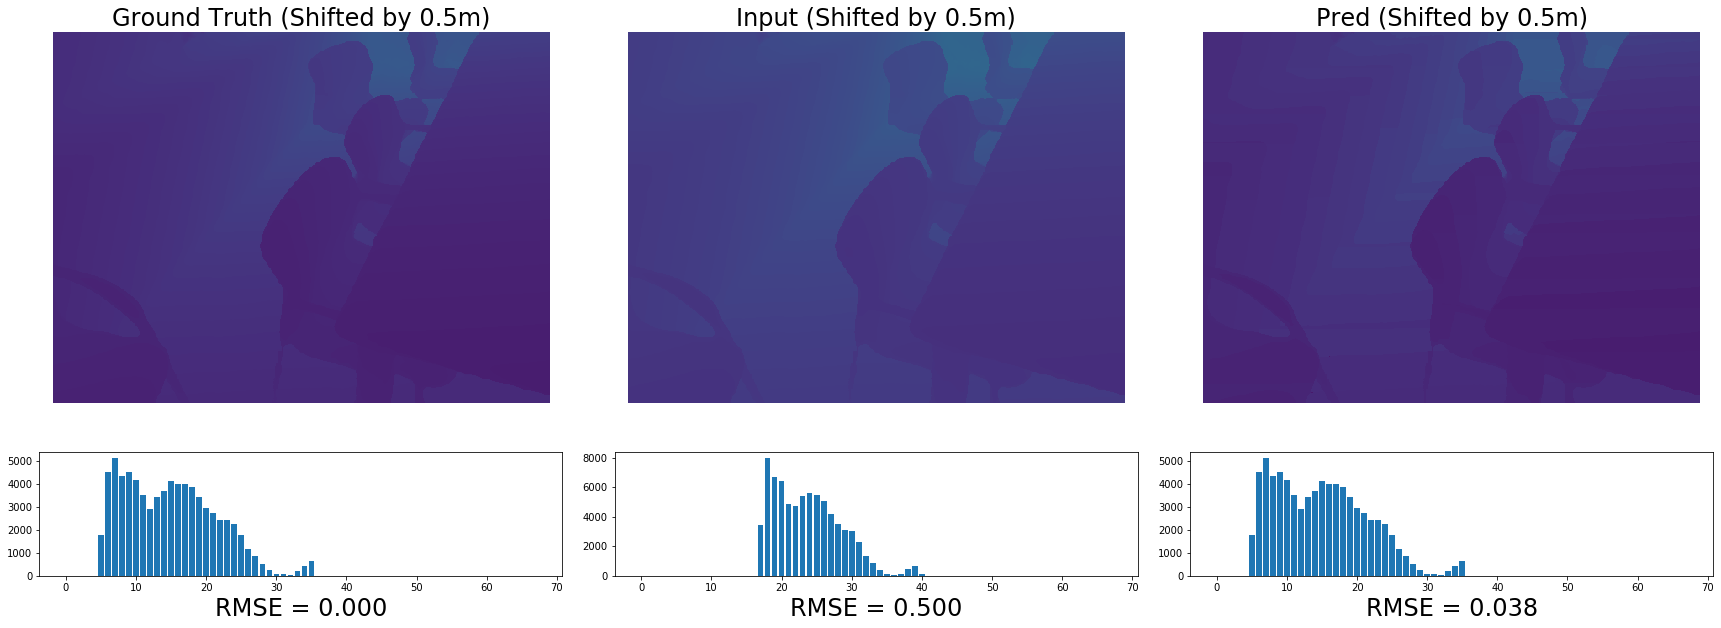

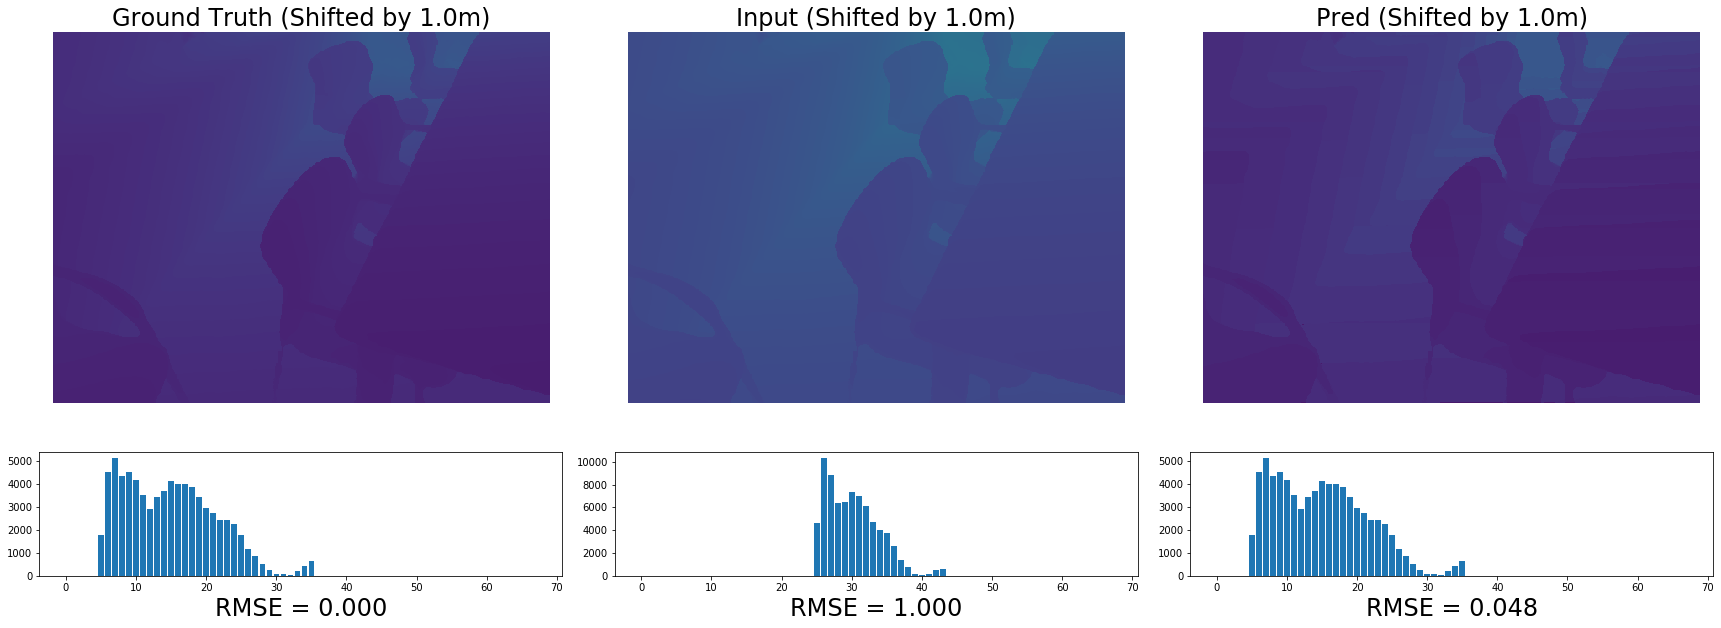

In [7]:
# Shifted
times = [run_and_display(gt + shift, gt, intensity, intensity, sid_obj, "Shifted by {}m".format(shift))
         for shift in [0.01, 0.1, 0.5, 1.]]
print("Average time: {}".format(np.mean(times)))

In [ ]:
# Noisy Intensity
noisy_intensity = np.clip(intensity + 0.05*np.random.randn(*intensity.shape),
                          a_min=0.02, a_max=1.)
times = [run_and_display(gt+0.2, gt, noisy_intensity, intensity, sid_obj, "Noisy Intensity, std=0.05") for _ in range(10)]
print("Average time: {}".format(np.mean(times)))

In [ ]:
# Noisy Depth
ns = np.clip(gt + 0.2*np.random.randn(*gt.shape), a_min=0.001, a_max=10.)
times = [run_and_display(ns, gt, intensity, intensity, sid_obj, "Noisy Depth, std=20cm") for _ in range(10)]
print("Average time: {}".format(np.mean(times)))